In [1]:
#carry out ML to extract urban areas. 
#can then extend this back in time to get when urban change took place.

In [2]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
#import sys
#sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr 
import odc.algo

# Bonus vector manipulation
import pandas as pd
import geopandas as gpd
from shapely import wkt
from datetime import datetime
import datacube

import dask

CMAP = "Blues"

In [3]:
from __future__ import print_function, division
from osgeo import gdal, gdal_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, cohen_kappa_score, mean_squared_error, classification_report
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image as ImageSave
from math import sqrt
import os
from IPython.display import Image

In [4]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [5]:
dc = datacube.Datacube(app = 'land_degredation')#, config = '/home/localuser/.datacube.conf')

from matplotlib.cm import RdYlGn, Greens
from odc.algo import to_f32, from_float, xr_geomedian
from datacube_utilities.dc_load import get_product_extents
from datacube_utilities.dc_time import dt_to_str
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
from datacube_utilities.dc_rgb import rgb
from datacube_utilities.createAOI import create_lat_lon
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.createindices import NDVI
from datacube_utilities.fromDCALscripts import threshold_plot
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
from datacube_utilities.dc_utilities import write_geotiff_from_xr
from datacube_utilities.import_export import export_xarray_to_multiple_geotiffs


In [190]:
###Load in image
#inputs
#options "LANDSAT_8", "LANDSAT_7", "LANDSAT_5", "LANDSAT_4" and "SENTINEL_2"
platform_base = "LANDSAT_8"
#For Fiji this should be the only option - may change for Solomon and Vanuatu
output_projection = "EPSG:3460"
crs = "EPSG:3460"
res = (30)

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

#set baseline start and end of period
baseline_start_date = '2018-1-1'
baseline_end_date = '2018-12-30'
#nadi
#aoi_wkt = "POLYGON((177.384445215936 -17.725841212511558,177.53619387316257 -17.725841212511558,177.53619387316257 -17.8278433805643,177.384445215936 -17.8278433805643,177.384445215936 -17.725841212511558))"

#suva
aoi_wkt = "POLYGON((178.39699689321165 -18.061332095979633,178.55080548696165 -18.061332095979633,178.55080548696165 -18.18467000208122,178.39699689321165 -18.18467000208122,178.39699689321165 -18.061332095979633))"

In [191]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [192]:
## The code below renders a map that can be used to orient yourself with the region.
display_map(latitude = lat_extents, longitude = lon_extents)

In [193]:
from pyproj import Proj, transform
inProj  = Proj("+init=EPSG:4326")
outProj = Proj("+init=EPSG:3460")
min_lat, max_lat = (lat_extents) 
min_lon, max_lon = (lon_extents)
x_A, y_A = transform(inProj, outProj, min_lon, min_lat)
x_B, y_B = transform(inProj, outProj, max_lon, max_lat)
lat_range = (y_A, y_B)
lon_range = (x_A, x_B)
print(lat_range)
print(lon_range)

(3868865.296636806, 3882539.0512192366)
(1962643.4711290102, 1978898.4636792026)


In [194]:
allmeasurements = ["green","red","blue","nir","swir1","swir2"]
#water_measurements = ["water_classification"]
def create_product_measurement(platform):
    if platform  in ["SENTINEL_2"]:
        product = 's2_esa_sr_granule'
        measurements = allmeasurements + ["coastal_aerosol","scene_classification"]
        ###CHANGE WHEN S2 WOFS READY
        water_product = 'SENTINEL_2_PRODUCT DEFS'
    elif platform in ["LANDSAT_8"]:    
        measurements = allmeasurements
        product = 'ls8_geomedian_annual'
        #water_product = 'ls8_water_classification'
    elif platform in ["LANDSAT_7"]:    
        measurements = allmeasurements
        product = 'ls7_geomedian_annual'
        #water_product = 'ls7_water_classification'
    elif platform in ["LANDSAT_5"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls5_usgs_sr_scene'
        water_product = 'ls5_water_classification'
    elif platform in ["LANDSAT_4"]:    
        measurements = allmeasurements + ["pixel_qa"]
        product = 'ls4_usgs_sr_scene'
        water_product = 'ls4_water_classification'
    else:
        print("invalid platform")
    return product

In [195]:
baseline_product = create_product_measurement(platform_base)

In [196]:
#create resolution
resolution = (-res, res)

In [197]:
dask_chunks = dict(
    x = 1000,
    y = 1000
)

In [198]:
#format dates
def createDate(inputStart, inputEnd):
    start = datetime.strptime(inputStart, '%Y-%m-%d')
    end = datetime.strptime(inputEnd, '%Y-%m-%d')
    startDates = start.date()
    endDates = end.date()
    time_period = (startDates, endDates)
    return time_period

baseline_time_period = createDate(baseline_start_date, baseline_end_date)

In [199]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes 
query = {
    'y': lat_range,
    'x': lon_range,
    'output_crs': output_projection,  
    'resolution': resolution,
    'dask_chunks': dask_chunks
}


In [200]:
baseline_ds = dc.load(
    time = baseline_time_period,
    product = baseline_product,
    platform = platform_base,
    crs = crs,
    **query
)


In [201]:
img_ds = baseline_ds.compute()

In [202]:
#calculate and add on other indices

In [203]:
#NDBI
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)
img_ds['ndbi'] = NDBI(img_ds)

In [204]:
#NDVI
from datacube_utilities.createindices import NDVI
img_ds['ndvi'] = NDVI(img_ds)

In [205]:
#MNDWI
def MNDWI(dataset):
    return (dataset.green - dataset.swir2)/(dataset.green + dataset.swir2)
img_ds['mndwi'] = MNDWI(img_ds)

In [206]:
#BU
img_ds['bu'] = img_ds['ndbi'] - img_ds['ndvi']

In [207]:
print(img_ds)

<xarray.Dataset>
Dimensions:  (time: 1, x: 543, y: 456)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (time, y, x) int16 -9999 -9999 -9999 190 170 ... 310 303 286 284
    green    (time, y, x) int16 -9999 -9999 -9999 431 552 ... 308 297 278 281
    red      (time, y, x) int16 -9999 -9999 -9999 339 451 ... 100 102 100 94 96
    nir      (time, y, x) int16 -9999 -9999 -9999 3024 3796 ... 30 31 32 29 28
    swir1    (time, y, x) int16 -9999 -9999 -9999 1228 1530 ... 40 41 40 39 39
    swir2    (time, y, x) int16 -9999 -9999 -9999 705 905 960 ... 31 32 31 31 31
    ndbi     (time, y, x) float64 -0.0 -0.0 -0.0 ... 0.1111 0.1471 0.1642
    ndvi     (time, y, x) float64 -0.0 -0.0 -0.0 ... -0.5152 -0.5285 -0.5484
    mndwi    (time, y, x) float64 -0.0 -0.0 -0.0 -0.2412 ... 0.811 0.7994 0.8013
    

In [208]:
T1_img = img_ds.isel(time = 0)

In [209]:
print(T1_img)

<xarray.Dataset>
Dimensions:  (x: 543, y: 456)
Coordinates:
    time     datetime64[ns] 2018-07-02
  * y        (y) float64 3.883e+06 3.882e+06 3.882e+06 ... 3.869e+06 3.869e+06
  * x        (x) float64 1.963e+06 1.963e+06 1.963e+06 ... 1.979e+06 1.979e+06
Data variables:
    blue     (y, x) int16 -9999 -9999 -9999 190 170 231 ... 300 310 303 286 284
    green    (y, x) int16 -9999 -9999 -9999 431 552 611 ... 299 308 297 278 281
    red      (y, x) int16 -9999 -9999 -9999 339 451 468 ... 99 100 102 100 94 96
    nir      (y, x) int16 -9999 -9999 -9999 3024 3796 4306 ... 27 30 31 32 29 28
    swir1    (y, x) int16 -9999 -9999 -9999 1228 1530 1693 ... 39 40 41 40 39 39
    swir2    (y, x) int16 -9999 -9999 -9999 705 905 960 ... 30 31 32 31 31 31
    ndbi     (y, x) float64 -0.0 -0.0 -0.0 -0.4224 ... 0.1111 0.1471 0.1642
    ndvi     (y, x) float64 -0.0 -0.0 -0.0 0.7984 ... -0.5152 -0.5285 -0.5484
    mndwi    (y, x) float64 -0.0 -0.0 -0.0 -0.2412 ... 0.811 0.7994 0.8013
    bu       (y, 

In [210]:
#write_geotiff_from_xr('img_ds.tiff', T1_img, crs=output_projection, x_coord = 'x', y_coord = 'y')

In [211]:
def export_slice_to_geotiff(ds, path, x_coord='longitude', y_coord='latitude'):
    """
    Exports a single slice of an xarray.Dataset as a GeoTIFF.
    ds: xarray.Dataset
        The Dataset to export. Must have exactly 2 dimensions - 'latitude' and 'longitude'.
    x_coord, y_coord: string
        Names of the x and y coordinates in `ds`.
    path: str
        The path to store the exported GeoTIFF.
    """
    kwargs = dict(tif_path=path, data=ds.astype(np.float32), bands=list(ds.data_vars.keys()),
                  x_coord=x_coord, y_coord=y_coord)
    if 'crs' in ds.attrs:
        kwargs['crs'] = str(ds.attrs['crs'])
    write_geotiff_from_xr(**kwargs)


In [212]:
export_slice_to_geotiff(T1_img, 'tester.tif', x_coord = 'x', y_coord = 'y')

In [213]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [214]:
## vector to raster wtih same res as input raster

In [217]:
from osgeo import gdal
from osgeo import ogr
from osgeo import gdalconst

#dataset from which to base pixel size and extent for rasterization of training datasets
ndsm = 'tester.tif'
#training data
shp = 'attempt105.geojson'
#openlayers
data = gdal.Open(ndsm, gdalconst.GA_ReadOnly)
geo_transform = data.GetGeoTransform()
#source_layer = data.GetLayer()
#get dimensions
x_min = geo_transform[0]
y_max = geo_transform[3]
x_max = x_min + geo_transform[1] * data.RasterXSize
y_min = y_max + geo_transform[5] * data.RasterYSize
x_res = data.RasterXSize
y_res = data.RasterYSize
mb_v = ogr.Open(shp)
mb_l = mb_v.GetLayer()
pixel_width = geo_transform[1]
#name for output of rasterized geotif
output = 'my2_new.tif'

target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
proj=data.GetProjection() #y
target_ds.SetProjection(proj)
#target_ds.SetGeoTransform((x_min, pixel_width, 0, y_min, 0, pixel_width))
geotrans=data.GetGeoTransform()  #get GeoTranform from existed 'data0'

band = target_ds.GetRasterBand(1)
NoData_value = -999999
band.SetNoDataValue(NoData_value)
band.FlushCache()
target_ds.SetGeoTransform(geotrans)
gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE=Class"])


target_ds = None

In [218]:
#path to image
#path to training/test data
#roi_ds = gdal.Open('testoutput.tif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('my2_new.tif', gdal.GA_ReadOnly)
img_ds = gdal.Open('tester.tif', gdal.GA_ReadOnly)

In [219]:
roi_dataset = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

In [220]:
print(roi_dataset.max())

5


roi = np.zeros((roi_ds.RasterYSize, roi_ds.RasterXSize, roi_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(roi_ds.GetRasterBand(1).DataType))
for b in range(roi.shape[2]):
    roi[:, :, b] = roi_ds.GetRasterBand(b + 1).ReadAsArray()
print(roi)

In [221]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    print(b)
print(img)

0
1
2
3
4
5
6
7
8
9
[[[-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  [-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  [-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  ...
  [ 4.88e+02  8.53e+02  7.54e+02 ...  6.02e-01 -1.70e-01 -8.31e-01]
  [ 3.11e+02  6.77e+02  5.30e+02 ...  7.46e-01 -1.63e-01 -1.06e+00]
  [ 4.63e+02  8.87e+02  7.09e+02 ...  6.99e-01 -1.71e-01 -9.94e-01]]

 [[-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  [-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  [-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  ...
  [ 3.81e+02  7.54e+02  5.90e+02 ...  7.29e-01 -1.63e-01 -1.05e+00]
  [ 2.54e+02  6.60e+02  4.06e+02 ...  8.36e-01 -1.76e-01 -1.21e+00]
  [ 3.87e+02  7.82e+02  6.11e+02 ...  7.30e-01 -1.65e-01 -1.04e+00]]

 [[-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  [-1.00e+04 -1.00e+04 -1.00e+04 ... -0.00e+00 -0.00e+00  0.00e+00]
  [-1.00e+04

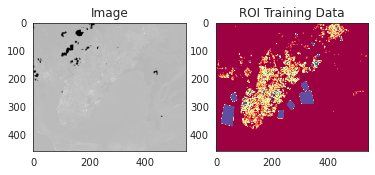

In [222]:
# Display the image and the Training/Test raster
plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('Image')
plt.subplot(122)
plt.imshow(roi_dataset, cmap=plt.cm.Spectral, vmin=0, vmax=0.5)
plt.title('ROI Training Data')
plt.show()

In [223]:
labels = np.unique(roi_dataset[roi_dataset > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))

The training data include 5 classes: [1 2 3 4 5]


In [224]:
#set X and y as image and training/test data.
X = img[roi_dataset > 0, :]
y = roi_dataset[roi_dataset > 0 ]

In [225]:
#Split the data into training and testing, by 80:20 split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [226]:
unique, counts = np.unique(y_train, return_counts=True)
dict_ytrain = dict(zip(unique, counts))
unique2, counts2 = np.unique(y_test, return_counts=True)
dict_ytest = dict(zip(unique2,counts2))
print("counts")
print('Train counts', counts)
print('Test counts', counts2)


counts
Train counts [4706   71   61 4671   75]
Test counts [1177   18   15 1168   19]


In [227]:
# Initialize random forest model with 200 trees, and balanced class weight
rf = RandomForestClassifier(n_estimators=200, oob_score=True, class_weight="balanced", min_samples_leaf=100)
rf = rf.fit(X_train,y_train)

In [228]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 90.1085141903172%


In [229]:
# Setup a dataframe, for truth and predicted values of training data
df = pd.DataFrame()
df['truth'] = y_train
df['predict'] = rf.predict(X_train)
# Setup a dataframe, for truth and predicted values of test data
df2 = pd.DataFrame()
df2['truth'] = y_test
df2['predict'] = rf.predict(X_test)

In [230]:
# Cross-tabulate predictions
print(pd.crosstab(df2['truth'], df2['predict'], margins=True))

predict    1   2   3     4    5   All
truth                                
1        926  18  66     3  164  1177
2          0  18   0     0    0    18
3          1   0  13     0    1    15
4          0   0   0  1168    0  1168
5          1   0   2     0   16    19
All      928  36  81  1171  181  2397


In [231]:
#calculate kappa score
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict'])) *100
kappaScore = cohen_kappa_score(df2['truth'], df2['predict'])
kSPer = kappaScore*100
print("this is kappa", kSPer) 
#print("this is kappa", cohen_kappa_score(df2['truth'], df2['predict']))


this is kappa 81.29354944619782


In [232]:
#calculate accuracy score
print('accuracy score', accuracy_score(df2['truth'], df2['predict']))
#print classification report
print(classification_report(df2['truth'], df2['predict']))

accuracy score 0.8931998331247393
              precision    recall  f1-score   support

           1       1.00      0.79      0.88      1177
           2       0.50      1.00      0.67        18
           3       0.16      0.87      0.27        15
           4       1.00      1.00      1.00      1168
           5       0.09      0.84      0.16        19

    accuracy                           0.89      2397
   macro avg       0.55      0.90      0.60      2397
weighted avg       0.98      0.89      0.93      2397



In [233]:
#This function prints and plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          cmap=plt.cm.Blues, annot=True, annot_kws={"size": 3}):
    # Compute confusion matrix
    cm = confusion_matrix(df2['truth'], df2['predict'])
    # Only use the labels that appear in the data
    #classes = ('Built-up', 'Forest', 'Water', 'Grass', 'WB', 'WW', 'OSR')
    classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')
    print("diagonal", cm.diagonal()/cm.sum(axis=1))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    VALUE_SIZE = 10
    LABEL_SIZE = 12

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #show tick labels and label them with list enteries.
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize = LABEL_SIZE)
    plt.setp(ax.get_yticklabels(), fontsize = LABEL_SIZE)
    #path for output of normalised and non-normalised confusion matrices
    notn = 'cm.png'
    norm = 'ncm.png'

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center", fontsize=VALUE_SIZE,
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #save the outputs on the confusion matrices
    if normalize:
        plt.savefig(norm)
        print("saved to", norm)
    else:
        plt.savefig(notn)
        print("saved to", notn)
    return ax


diagonal [0.79 1.   0.87 1.   0.84]
Confusion matrix, without normalization
[[ 926   18   66    3  164]
 [   0   18    0    0    0]
 [   1    0   13    0    1]
 [   0    0    0 1168    0]
 [   1    0    2    0   16]]
saved to cm.png
diagonal [0.79 1.   0.87 1.   0.84]
Normalized confusion matrix
[[0.79 0.02 0.06 0.   0.14]
 [0.   1.   0.   0.   0.  ]
 [0.07 0.   0.87 0.   0.07]
 [0.   0.   0.   1.   0.  ]
 [0.05 0.   0.11 0.   0.84]]
saved to ncm.png


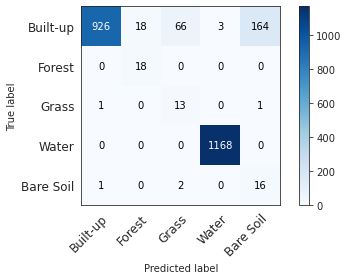

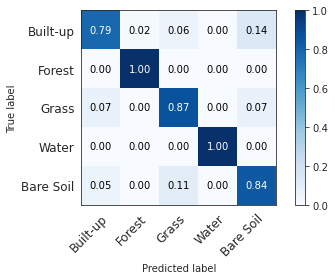

In [234]:
#class labels
classes = ('Built-up', 'Forest', 'Grass', 'Water', 'Bare Soil')

np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes)

# Plot normalized confusion matrix
plot_confusion_matrix(df2['truth'], df2['predict'], classes=classes, normalize=True)
plt.show()



In [235]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

In [236]:
# Now predict each pixel in the image.
class_prediction = rf.predict(img_as_array)

In [237]:
# Reshape classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print(np.unique(class_prediction))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [238]:
print(class_prediction.shape)
xsize = class_prediction.shape[0]
ysize = class_prediction.shape[1]
print(xsize)

(456, 543)
456


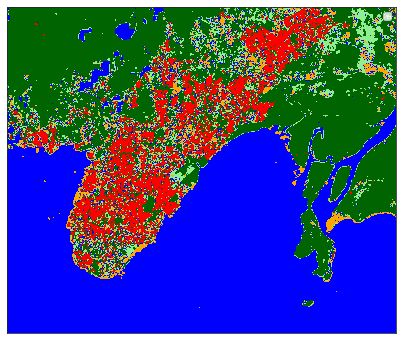

In [239]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction))
plt.show()

In [125]:
dst_filename = 'xxx.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction)

# follow code is adding GeoTranform and Projection
geotrans=img_ds.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

## Test on new area

In [89]:
img_ds2 = gdal.Open('tester2.tif', gdal.GA_ReadOnly)

In [90]:
img2 = np.zeros((img_ds2.RasterYSize, img_ds2.RasterXSize, img_ds2.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds2.GetRasterBand(1).DataType))
#print(img.dtype)
for b in range(img2.shape[2]):
    img2[:, :, b] = img_ds2.GetRasterBand(b + 1).ReadAsArray()
    print(b)
print(img2)

0
1
2
3
4
5
6
7
8
9
[[[ 2.70e+02  2.16e+02  6.40e+01 ... -2.80e-01  8.15e-01  1.55e-01]
  [ 2.73e+02  2.20e+02  6.70e+01 ... -2.88e-01  8.03e-01  1.67e-01]
  [ 2.76e+02  2.21e+02  7.00e+01 ... -2.84e-01  7.97e-01  1.70e-01]
  ...
  [ 2.13e+02  5.01e+02  4.00e+02 ...  7.75e-01 -3.00e-01 -1.04e+00]
  [ 3.00e+02  6.22e+02  5.42e+02 ...  7.12e-01 -2.57e-01 -9.42e-01]
  [ 3.84e+02  7.15e+02  6.83e+02 ...  6.35e-01 -1.95e-01 -8.58e-01]]

 [[ 2.62e+02  2.14e+02  6.30e+01 ... -2.73e-01  8.29e-01  1.30e-01]
  [ 2.65e+02  2.13e+02  6.40e+01 ... -2.93e-01  8.21e-01  1.64e-01]
  [ 2.70e+02  2.18e+02  6.70e+01 ... -3.27e-01  8.09e-01  2.64e-01]
  ...
  [ 2.52e+02  5.86e+02  4.00e+02 ...  8.06e-01 -2.52e-01 -1.09e+00]
  [ 2.75e+02  5.97e+02  4.10e+02 ...  8.03e-01 -2.52e-01 -1.09e+00]
  [ 2.66e+02  5.87e+02  4.00e+02 ...  8.07e-01 -2.46e-01 -1.10e+00]]

 [[ 2.63e+02  2.16e+02  6.20e+01 ... -3.19e-01  8.38e-01  2.34e-01]
  [ 2.65e+02  2.17e+02  6.40e+01 ... -3.20e-01  8.31e-01  2.55e-01]
  [ 2.66e+02

In [91]:
# Use full image, reshape to 2darray for classification (nrow * ncol, nband)
new_shape2 = (img2.shape[0] * img2.shape[1], img2.shape[2])
img_as_array2 = img2[:, :, :].reshape(new_shape2)

In [92]:
# Now predict each pixel in the image.
class_prediction2 = rf.predict(img_as_array2)

In [93]:
# Reshape classification map
class_prediction2 = class_prediction2.reshape(img2[:, :, 0].shape)
print(np.unique(class_prediction2))
#im = ImageSave.fromarray(class_prediction)
#im.save('map.tif')

[1 2 3 4 5]


In [94]:
print(class_prediction2.shape)
xsize2 = class_prediction2.shape[0]
ysize2 = class_prediction2.shape[1]
print(xsize2)

(381, 534)
381


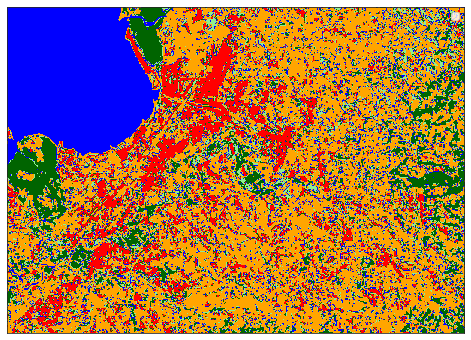

In [95]:
# use seaborne raster plots
sns.set_style("white")
#set colours for each class
colors = ['red', 'darkgreen', 'lightgreen', 'blue', 'orange']
cmap = ListedColormap(colors)
# Plot newly classified and masked raster
fig, ax = plt.subplots(figsize = (10,6))
ax.imshow(class_prediction2, cmap = cmap)
ax.set_yticks([])
ax.set_xticks([])
ax.legend(np.unique(class_prediction2))
plt.show()

In [96]:
dst_filename = 'xxx2.tiff'
x_pixels = ysize  # number of pixels in x
y_pixels = xsize  # number of pixels in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(class_prediction2)

# follow code is adding GeoTranform and Projection
geotrans=img_ds2.GetGeoTransform()  #get GeoTranform from existed 'data0'
proj=img_ds2.GetProjection() #you can get from a exsited tif or import 
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None